# 1. Build an image segmentation model using pytorch

Library import

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from glob import glob
from sklearn.model_selection import train_test_split

In [2]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision import transforms as T
from glob import glob
from PIL import Image
import numpy as np
from PIL import Image
import pandas as pd
import os

In [3]:
import torchvision
import torchvision.datasets as datasets
from torchvision import models

In [4]:
class SegmentationNet(nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        
       #Encoder
        
        resnet=models.resnet101(pretrained=True)
        self.encoder=nn.Sequential(*list(resnet.children())[:-2])
        
     
        #Decoder 
        
     
        self.conv5=nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm5=    nn.BatchNorm2d(64)
        self.relu5=  nn.ReLU()
        self.conv6=   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm6 =  nn.BatchNorm2d(64)
        self.relu6  =  nn.ReLU()
        self.convTrans4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.conv7=    nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm7=  nn.BatchNorm2d(32)
        self.relu7=    nn.ReLU()
        self.conv8=    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm8=  nn.BatchNorm2d(32)
        self.relu8=   nn.ReLU()
      
        self.convTrans5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        #Segmentation

        self.conv9=nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding=0)
        self.norm9=  nn.BatchNorm2d(8)
        self.relu9= nn.ReLU()
        self.conv10=  nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0)
        self.norm10=  nn.BatchNorm2d(2)
        self.relu10  = nn.ReLU()

        
    def forward(self, x): 
        
        
       #Encoder
        
        x=self.encoder[0](x)
        x=self.encoder[1](x)
        x=self.encoder[2](x)
        x=self.encoder[3](x)

        #Decoder 
        
     
        x=self.conv5(x)
        x=self.norm5(x)
        x=self.relu5(x)
        x=self.conv6(x)
        x=self.norm6(x)
        x=self.relu6(x)
        x=self.convTrans4(x)
        
        x=self.conv7(x)
        x=self.norm7(x)
        x=self.relu7(x)
        x=self.conv8(x)
        x=self.norm8(x)
        x=self.relu8(x)
      
        x=self.convTrans5(x)
        
        #Segmentation

        x=self.conv9(x)
        x=self.norm9(x)
        x=self.relu9(x)
        x=self.conv10(x)
        x=self.norm10(x)
        x=self.relu10(x)
        

        return x

In [5]:
device='cuda' if torch.cuda.is_available() else 'cpu'

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)

# Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_data_path = r"/content/drive/MyDrive/Datasets/YU/Lung_segmentation/Train"
test_data_path = r"/content/drive/MyDrive/Datasets/YU/Lung_segmentation/Test"

In [8]:
img_size=(256,256)

In [9]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize,ToPILImage


In [10]:
img_transform = Compose([ToPILImage(),
                                    Resize(img_size),
                                    ToTensor(),
                                    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [11]:
pin_memory=True

In [12]:
TRAIN_BATCH_SIZE=16

In [13]:
TEST_BATCH_SIZE=8

In [14]:
from torchvision.transforms import Compose


In [15]:
def import_folder_dataset(root_path, resized_size):
    # Initialize empty lists for images, masks, and binary masks
    image_list = []
    mask_list = []
    binary_mask_list = []

    # Build the paths for the images and masks directories
    image_dir = os.path.join(root_path, "Images")
    mask_dir = os.path.join(root_path, "Masks")

    # List all the image names in the images directory
    image_names = os.listdir(image_dir)

    # Loop over all the images and corresponding masks
    for image_name in image_names:
        # Build the paths for the image and the corresponding mask
        image_path = os.path.join(image_dir, image_name)
        mask_path = os.path.join(mask_dir, image_name)

        # Load the image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)

        # Resize the image and mask to the specified size
        image = cv2.resize(image, resized_size)
        mask = cv2.resize(mask, resized_size)

        # Convert the mask to a binary mask
        binary_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        binary_mask = (binary_mask / 255).astype(np.uint8)

        # Add the image and masks to their respective lists
        image_list.append(image)
        mask_list.append(mask)
        binary_mask_list.append(binary_mask)

    # Convert the lists to numpy arrays and return them
    return np.array(image_list), np.array(mask_list), np.array(binary_mask_list)


In [16]:
class Data(Dataset):
    def __init__(self, X_element, m_element, y_element, transform):
        # Save images
        self.X = X_element
        # Save mask images
        self.m = m_element
        # Save segmentation classes
        self.y = torch.from_numpy(y_element).type(torch.LongTensor)
        
        self.transform = transform
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        
        item = self.X[index]
        item = self.transform(item)
        
        return item, self.m[index], self.y[index]




In [17]:
def calculate_IOU(pred, label):
    # Flatten the predictions and labels tensors
    pred = pred.view(pred.size(0), -1)
    label = label.view(label.size(0), -1)

    # Calculate the intersection and union
    intersection = (pred * label).sum(dim=1)
    union = pred.sum(dim=1) + label.sum(dim=1) - intersection

    # Calculate the IOU
    iou = intersection / union.clamp(min=1e-8)

    return iou

In [18]:
def calculate_Dice(pred, label):
    # Flatten the predictions and labels tensors
    pred = pred.view(pred.size(0), -1)
    label = label.view(label.size(0), -1)

    # Calculate the intersection and union
    intersection = (pred * label).sum(dim=1)
    union = pred.sum(dim=1) + label.sum(dim=1)

    # Calculate the Dice coefficient
    dice = 2 * intersection / union.clamp(min=1e-8)

    return dice

In [55]:
def predict(loader, model, inv_transform, device):
    model.eval()

    image_list = []
    target_mask_list = []
    predicted_mask_list = []
    accumulated_iou = 0
    accumulated_dice = 0
    total = 0
    with torch.no_grad():
        for bi, data in enumerate(loader):

            # Use the model to get predictions
            images = data[0].to(device)
            target_masks = data[2].to(device)
            outputs = model(images)

            # Calculate IoU and Dice
            predicted_masks = torch.argmax(outputs, dim=1)
            total += target_masks.size(0)

            iou = calculate_IOU(predicted_masks, target_masks)
            accumulated_iou += iou.sum().item()

            dice = calculate_Dice(predicted_masks, target_masks)
            accumulated_dice += dice.sum().item()

            # Invert the image transformation and reorder to an image format
            image = np.moveaxis(inv_transform(data[0][0]).numpy(), 0, -1)

            image_list.append(image)
            target_mask_list.append(data[2][0].detach().cpu().numpy())
            predicted_mask_list.append(predicted_masks[0].detach().cpu().numpy())

    mean_iou = accumulated_iou / total
    mean_dice = accumulated_dice / total
    return mean_iou, mean_dice, image_list, target_mask_list, predicted_mask_list


In [20]:
img_transform = Compose([ToPILImage(),
                                    Resize(img_size),
                                    ToTensor(),
                                    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [22]:
train_data, train_mask, train_labels = import_folder_dataset(root_path = train_data_path, resized_size = img_size)

print("Dim of Data: ", train_data.shape)
print("Dim of Mask: ", train_mask.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (800, 256, 256, 3)
Dim of Mask:  (800, 256, 256, 3)
Dim of Lables:  (800, 256, 256)


In [23]:
X_train, X_val, m_train, m_val, y_train, y_val = train_test_split(train_data, train_mask, train_labels, test_size=0.1, random_state=42)

Split on train and validation data

In [24]:
train_Dataset = Data(X_train, m_train, y_train, img_transform) 
val_Dataset = Data(X_val, m_val, y_val, img_transform)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  720
Val len:  80


Create the data loadera

In [25]:
train_dl = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_dl = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

Create the dataloaders

In [26]:
train_loader = DataLoader(train_dl, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(valid_dl, batch_size=TEST_BATCH_SIZE,shuffle=False)

# Set model parametes

In [36]:
model=SegmentationNet().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
criterion=nn.CrossEntropyLoss()

In [38]:
parameters=filter(lambda p: p.requires_grad,model.parameters())

In [39]:
lr=0.01

In [40]:
optim=torch.optim.Adam(parameters,lr=lr)

In [41]:
model

SegmentationNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

Train model

In [34]:
batch=20

In [42]:
train_loss, val_loss = [], []
train_IoU, val_IoU = [], []
num_epochs = 50

best_val_IoU = 0.8

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} of {num_epochs}:")
    
    # Train model
    model.train()
    running_loss = 0
    total = 0
    accumulatedIoU = 0
    
    for images, _, labels in train_dl:
        images = images.to(device)
        labels = labels.to(device)
        
        out = model(images)
        loss = criterion(out, labels)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        running_loss += loss.item() * images.size(0)
        
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        
        iou = calculate_IOU(predictions, labels)
        accumulatedIoU += iou.sum().item()
    
    train_epoch_loss = running_loss / len(train_dl.dataset)
    train_epoch_IoU = accumulatedIoU / total
    
    # Evaluate model
    model.eval()
    running_loss = 0
    total = 0
    accumulatedIoU = 0
    
    with torch.no_grad():
        for images, _, labels in valid_dl:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            predictions = torch.argmax(outputs, dim=1)
            total += labels.size(0)

            iou = calculate_IOU(predictions, labels)
            accumulatedIoU += iou.sum().item()
           
    val_epoch_loss = running_loss / len(valid_dl.dataset) 
    val_epoch_IoU = accumulatedIoU / total
    
    print("Train Loss: {:.4f}".format(train_epoch_loss))
    print("Val Loss: {:.4f}".format(val_epoch_loss))
    print("Train IoU: {:.4f}".format(train_epoch_IoU))
    print("Val IoU: {:.4f}".format(val_epoch_IoU))

    # Save the model if the current validation IoU is better than the previous best IoU
    if val_epoch_IoU > best_val_IoU:
        best_val_IoU = val_epoch_IoU
        torch.save(model.state_dict(), 'model.pth')
        print("Model saved.")
    
    # Save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_IoU.append(train_epoch_IoU)
    val_IoU.append(val_epoch_IoU)


Epoch 1 of 50:
Train Loss: 0.5063
Val Loss: 0.5035
Train IoU: 0.4676
Val IoU: 0.4650
Epoch 2 of 50:
Train Loss: 0.3459
Val Loss: 0.5740
Train IoU: 0.5994
Val IoU: 0.5066
Epoch 3 of 50:
Train Loss: 0.2769
Val Loss: 0.4243
Train IoU: 0.6811
Val IoU: 0.5432
Epoch 4 of 50:
Train Loss: 0.2304
Val Loss: 0.4618
Train IoU: 0.7317
Val IoU: 0.5643
Epoch 5 of 50:
Train Loss: 0.2028
Val Loss: 0.2039
Train IoU: 0.7596
Val IoU: 0.7551
Epoch 6 of 50:
Train Loss: 0.1753
Val Loss: 0.1926
Train IoU: 0.7907
Val IoU: 0.7744
Epoch 7 of 50:
Train Loss: 0.1675
Val Loss: 0.3426
Train IoU: 0.7960
Val IoU: 0.6685
Epoch 8 of 50:
Train Loss: 0.1598
Val Loss: 0.2243
Train IoU: 0.8045
Val IoU: 0.7350
Epoch 9 of 50:
Train Loss: 0.1540
Val Loss: 0.1613
Train IoU: 0.8096
Val IoU: 0.7883
Epoch 10 of 50:
Train Loss: 0.1523
Val Loss: 0.1595
Train IoU: 0.8096
Val IoU: 0.8011
Model saved.
Epoch 11 of 50:
Train Loss: 0.1372
Val Loss: 0.1748
Train IoU: 0.8291
Val IoU: 0.7620
Epoch 12 of 50:
Train Loss: 0.1387
Val Loss: 0.166

The accuracy on training and validation data

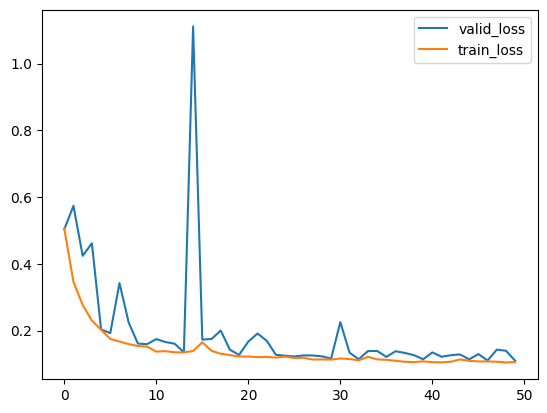

In [43]:
plt.plot(val_loss, label='valid_loss')
plt.plot(train_loss, label='train_loss')
plt.legend()

The IoU on training and validation data

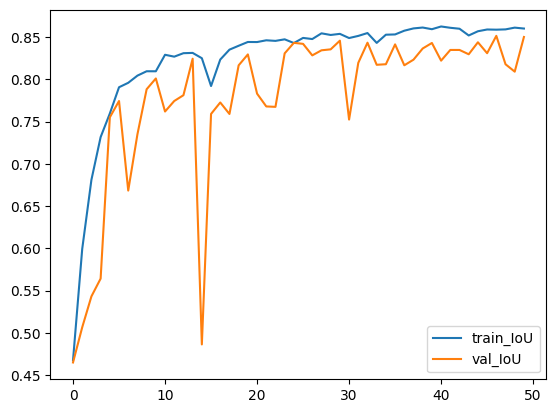

In [44]:
plt.plot(train_IoU, label='train_IoU')
plt.plot(val_IoU, label='val_IoU')
plt.legend()

# 3.Evaluate your model using the test images

In [45]:
invTrans = Compose([ Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [48]:
test_data, test_mask, test_labels = import_folder_dataset(root_path = test_data_path, resized_size = img_size)


print("Dim of Data: ", test_data.shape)
print("Dim of Mask: ", test_mask.shape)
print("Dim of Lables: ", test_labels.shape)
print("Dim of Data: ", test_data.shape)
print("Dim of Mask: ", test_mask.shape)
print("Dim of Lables: ", test_labels.shape)

Dim of Data:  (200, 256, 256, 3)
Dim of Mask:  (200, 256, 256, 3)
Dim of Lables:  (200, 256, 256)
Dim of Data:  (200, 256, 256, 3)
Dim of Mask:  (200, 256, 256, 3)
Dim of Lables:  (200, 256, 256)


In [58]:
# Create the dataset object
test_Dataset = Data(test_data, test_mask, test_labels, img_transform) 


print(f'Test len: {len(test_Dataset)}')

Test len: 200


In [50]:
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,
    shuffle=False
    )

In [51]:
clf=SegmentationNet().to(device)

In [52]:
with open('model.pth', 'rb') as f: 
    clf.load_state_dict(torch.load(f))

In [56]:
mean_IoU, mean_dice, image_list, mask_list, predictions_list = predict(loader = test_loader, 
                                                                     model = clf, 
                                                                     inv_transform = invTrans,
                                                                     device = device)
print(f'Average IoU of the model on the  Test dataset instances: { mean_IoU}')
print(f'Average Dice of the model on the  Test dataset instances: {mean_dice}')

Average IoU of the model on the  Test dataset instances: 0.8645689651370049
Average Dice of the model on the  Test dataset instances: 0.9255647987127305


# 4. Your IoU score should be higher than 0.8

# 5. Write a 2-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://www.researchgate.net/publication/370471146_Lung_Segmentation_of_Chest_X-ray_Images_using_Deep_Learning_and_Neural_Networks_methods

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points